# Outline

- create a model that predicts the category of each article by `LogisticRegression`
- train data is `matichon.json` that contains about 16K articles of Thai news by Matichon between 2015-2018
- X is text of `headline` or `article`
- y is category (10 labels)
- use `DictVectorizer` so that we could add other features than tokens

# Import

In [1]:
import pandas as pd
from collections import Counter
import re, emoji, urllib, html

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords

# Load data

- target variable is `category`
- `headline` and `article` are untokenized text

In [2]:
df = pd.read_json('data/matichon.json')
df

headline  \
0      ‡∏ã‡∏≤‡∏≠‡∏∏‡∏Ø‡∏à‡πà‡∏≠‡πÄ‡∏õ‡∏¥‡∏î‡πÑ‡∏ü‡πÄ‡∏Ç‡∏µ‡∏¢‡∏ß‡πÉ‡∏´‡πâ‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏´‡∏ç‡∏¥‡∏á‡∏°‡πà‡∏≤‡∏¢-‡∏´‡∏¢‡πà‡∏≤‡∏£‡πâ‡∏≤‡∏á‡∏õ‡∏Å...   
1      "‡πÑ‡∏Å‡πà‡∏≠‡∏π"‡∏ä‡∏µ‡πâ ‡∏ï‡∏π‡πà-‡πÄ‡∏ï‡πâ‡∏ô ‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ‡∏°‡∏µ‡∏´‡∏ô‡πâ‡∏≤‡∏ó‡∏µ‡πà‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ó‡∏∏‡∏à‡∏£...   
2      ‡πÄ‡∏õ‡∏¥‡∏î‡πÉ‡∏à "‡πÇ‡∏ö‡∏ß‡πå ‡πÅ‡∏ß‡∏ô‡∏î‡∏≤" ‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á‡∏£‡∏≠‡∏¢‡∏¥‡πâ‡∏°‡πÑ‡∏î‡πâ‡πÄ‡∏ï‡πá‡∏°‡∏ó‡∏µ‡πà‡πÉ‡∏ô‡∏ß...   
3      "‡∏ô‡∏≤‡∏¢ ‡∏ì‡∏†‡∏±‡∏ó‡∏£" ‡∏õ‡∏•‡∏∑‡πâ‡∏°‡∏Ñ‡∏ô‡∏ä‡∏°‡πÅ‡∏ä‡∏°‡∏õ‡πå‡∏Ç‡∏∂‡πâ‡∏ô‡∏õ‡∏Å‡∏ô‡∏¥‡∏ï‡∏¢‡∏™‡∏≤‡∏£‡πÅ‡∏´‡πà‡∏á‡∏õ‡∏µ ...   
4      ‡∏Ñ‡∏≠‡πÅ‡∏ó‡∏ö‡∏´‡∏±‡∏Å! ‡πÅ‡∏°‡πà‡∏¢‡∏Å‡πÅ‡∏´‡πà‡∏Ñ‡∏•‡πâ‡∏≠‡∏á‡∏û‡∏ß‡∏á‡∏°‡∏≤‡∏•‡∏±‡∏¢‡∏±‡∏Å‡∏©‡πå "‡∏ö‡∏≠‡∏¢ ‡∏®‡∏¥‡∏£‡∏¥‡∏ä...   
...                                                  ...   
17104  ‡πÇ‡∏ö‡∏ß‡πå ‡∏ì‡∏±‡∏è‡∏ê‡∏≤  ‡πÅ‡∏à‡πâ‡∏á‡∏Ñ‡∏ß‡∏≤‡∏° ‡∏û‡∏•.‡∏ï.‡∏≠.‡∏®‡∏£‡∏µ‡∏ß‡∏£‡∏≤‡∏´‡πå ‡∏ñ‡∏π‡∏Å‡∏û‡∏≤‡∏î‡∏û‡∏¥‡∏á...   
17105  ‡∏†‡∏≤‡∏û‡∏ö‡∏£‡∏£‡∏¢‡∏≤‡∏Å‡∏≤‡∏® ‡∏Ç‡∏∏‡∏î‡∏ó‡∏≤‡∏á‡∏£‡∏∞‡∏ö‡∏≤‡∏¢‡∏ô‡πâ‡∏≥ ‡πÄ‡∏£‡πà‡∏á‡∏ô‡∏≥ 13 ‡∏ä‡∏µ‡∏ß‡∏¥‡∏ï‡∏≠‡∏≠‡∏Å‡∏à...   
17106  ‡∏™‡∏ô‡∏ä.‡∏ú‡πà‡∏≤‡∏ô‡∏û.‡∏£.‡∏ö.‡∏™‡∏á‡∏Ü‡πå 3 ‡∏ß‡∏≤‡∏£‡∏∞‡∏£‡∏ß‡∏î ‡∏û‡∏£‡∏∞‡∏°‡∏´‡∏≤‡∏Å‡∏©‡∏±‡∏ï‡∏£‡∏¥‡∏¢‡πå‡∏ó‡∏£‡∏á...   
17107  ‡∏ô‡∏≤‡∏ô‡∏≤‡∏ó‡∏£‡∏£‡∏®‡∏ô‡∏∞‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ñ‡πà‡∏≤‡∏õ‡∏£‡∏±‡∏ö¬ù‡∏´‡∏°‡∏≠¬û 5‡∏•‡πâ‡∏≤‡∏ô‡∏ö. ‡∏™‡∏Å‡∏±‡∏î‡πÄ‡∏ö‡∏µ‡πâ‡∏¢‡∏ß...   
17108  ‡∏ß‡∏≠‡∏ô!! ‡∏ô‡∏≤‡∏¢‡∏Å ‡∏™.‡∏õ‡∏™.‡∏Å‡∏ä.‡∏ä‡∏á '‡∏ö‡∏¥‡πä‡∏Å‡∏à‡∏¥‡∏ô' ‡∏ä‡πà‡∏ß‡∏¢ ‡∏ô.‡∏£.‡πÄ‡∏≠‡∏Å‡∏ä‡∏ô...   

                                                 article                date  \
0      (2 ‡∏ò.‡∏Ñ.58) ‡∏´‡∏ô‡∏±‡∏á‡∏™‡∏∑‡∏≠‡∏û‡∏¥‡∏°‡∏û‡πå‡∏≠‡∏±‡∏• ‡∏£‡∏¥‡∏¢‡∏≤‡∏î‡∏Ç‡∏≠‡∏á‡∏ó‡∏≤‡∏á‡∏Å‡∏≤‡∏£‡∏ã‡∏≤‡∏≠‡∏∏‡∏î... 2015-12-04 03:35:18   
1      "‡∏ö‡∏¥‡πä‡∏Å‡∏õ‡πâ‡∏≠‡∏°" ‡πÅ‡∏à‡∏á ‡∏Ñ‡∏£‡∏°. ‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏û‡∏¢‡∏≤‡∏¢‡∏≤‡∏°‡∏¢‡∏∏‡∏¢‡∏á‡∏õ‡∏•‡∏∏‡∏Å‡∏õ‡∏±‡πà‡∏ô‡πÉ‡∏´... 2015-12-04 04:10:49   
2      ‡πÅ‡∏°‡πâ‡∏à‡∏∞‡∏ó‡∏≥‡∏´‡∏ô‡πâ‡∏≤‡∏ó‡∏µ‡πà‡∏†‡∏£‡∏£‡∏¢‡∏≤‡∏ó‡∏µ‡πà‡∏î‡∏µ‡∏°‡∏≤‡πÄ‡∏ù‡πâ‡∏≤‡∏õ‡∏≠ ‚Äì ‡∏ó‡∏§‡∏©‡∏é‡∏µ ‡∏™‡∏´‡∏ß‡∏á‡∏©... 2015-12-04 06:30:11   
3      ‡∏Å‡∏•‡∏≤‡∏¢‡πÄ‡∏õ‡πá‡∏ô‡∏î‡∏≤‡∏£‡∏≤‡∏´‡∏ô‡∏∏‡πà‡∏°‡πÄ‡∏ô‡∏∑‡πâ‡∏≠‡∏´‡∏≠‡∏°‡πÅ‡∏ü‡∏ô‡∏Ñ‡∏•‡∏±‡∏ö‡πÅ‡∏ô‡πà‡∏ô ‡∏Å‡∏£‡∏∞‡πÅ‡∏™‡∏°‡∏≤‡πÅ‡∏£... 2015-12-04 07:10:26   
4      ‡πÅ‡∏™‡∏î‡∏á‡∏î‡∏µ‡∏à‡∏ô‡πÄ‡∏õ‡πá‡∏ô‡∏ó‡∏µ‡πà‡∏ñ‡∏π‡∏Å‡∏≠‡∏Å‡∏ñ‡∏π‡∏Å‡πÉ‡∏à‡πÅ‡∏ü‡∏ô‡∏Ñ‡∏•‡∏±‡∏ö ‡∏à‡∏ô‡πÑ‡∏î‡πâ‡∏£‡∏±‡∏ö‡∏û‡∏ß‡∏á‡∏°‡∏≤... 2015-12-05 05:26:20   
...                                                  ...                 ...   
17104  ‡πÄ‡∏°‡∏∑‡πà‡∏≠‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà 5 ‡∏Å.‡∏Ñ. ‡∏ó‡∏µ‡πà ‡∏™‡∏ô.‡∏û‡∏ç‡∏≤‡πÑ‡∏ó ‡∏ô.‡∏™.‡∏ì‡∏±‡∏è‡∏ê‡∏≤ ‡∏°‡∏´‡∏±‡∏ó... 2018-07-05 13:25:45   
17105  ‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà 5 ‡∏Å‡∏£‡∏Å‡∏é‡∏≤‡∏Ñ‡∏° ‡πÄ‡∏à‡πâ‡∏≤‡∏´‡∏ô‡πâ‡∏≤‡∏ó‡∏µ‡πà‡∏Ç‡∏∏‡∏î‡∏ó‡∏≤‡∏á‡∏£‡∏∞‡∏ö‡∏≤‡∏¢‡∏ô‡πâ‡∏≥‡∏ó‡∏µ‡πà‡∏î... 2018-07-05 13:33:10   
17106  ‡∏™‡∏ô‡∏ä.‡∏ú‡πà‡∏≤‡∏ô ‡∏û.‡∏£.‡∏ö.‡∏™‡∏á‡∏Ü‡πå 3 ‡∏ß‡∏≤‡∏£‡∏∞‡∏£‡∏ß‡∏î "‡∏ß‡∏¥‡∏©‡∏ì‡∏∏" ‡πÅ‡∏à‡∏á‡∏™‡∏≤‡∏£‡∏∞‡∏™... 2018-07-05 13:33:27   
17107  ‡∏´‡∏°‡∏≤‡∏¢‡πÄ‡∏´‡∏ï‡∏∏ ‚Äì ‡∏à‡∏≤‡∏Å‡∏Å‡∏£‡∏ì‡∏µ‡∏ó‡∏µ‡πà ‡∏Å‡∏£‡∏∞‡∏ó‡∏£‡∏ß‡∏á‡∏®‡∏∂‡∏Å‡∏©‡∏≤‡∏ò‡∏¥‡∏Å‡∏≤‡∏£ (‡∏®‡∏ò.) ... 2018-07-05 13:53:26   
17108  ‡πÄ‡∏°‡∏∑‡πà‡∏≠‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà 5 ‡∏Å‡∏£‡∏Å‡∏£‡∏é‡∏≤‡∏Ñ‡∏° ‡∏ô‡∏≤‡∏¢‡∏®‡∏∏‡∏†‡πÄ‡∏™‡∏è‡∏ê‡πå ‡∏Ñ‡∏ì‡∏≤‡∏Å‡∏π‡∏• ‡∏ô‡∏≤‡∏¢‡∏Å... 2018-07-06 04:46:18   

            category                                                url  \
0            foreign        https://www.matichon.co.th/foreign/news_293   
1           politics       https://www.matichon.co.th/politics/news_329   
2      entertainment  https://www.matichon.co.th/entertainment/news_375   
3      entertainment  https://www.matichon.co.th/entertainment/news_393   
4      entertainment  https://www.matichon.co.th/entertainment/news_445   
...              ...                                                ...   
17104       politics   https://www.matichon.co.th/politics/news_1029607   
17105         region     https://www.matichon.co.th/region/news_1029619   
17106       politics   https://www.matichon.co.th/politics/news_1029636   
17107      education  http

In [3]:
## drop "date", "url", and "id"
df.drop(columns=['date','url','id'], inplace=True)
df.head()

headline  \
0  ‡∏ã‡∏≤‡∏≠‡∏∏‡∏Ø‡∏à‡πà‡∏≠‡πÄ‡∏õ‡∏¥‡∏î‡πÑ‡∏ü‡πÄ‡∏Ç‡∏µ‡∏¢‡∏ß‡πÉ‡∏´‡πâ‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏´‡∏ç‡∏¥‡∏á‡∏°‡πà‡∏≤‡∏¢-‡∏´‡∏¢‡πà‡∏≤‡∏£‡πâ‡∏≤‡∏á‡∏õ‡∏Å...   
1  "‡πÑ‡∏Å‡πà‡∏≠‡∏π"‡∏ä‡∏µ‡πâ ‡∏ï‡∏π‡πà-‡πÄ‡∏ï‡πâ‡∏ô ‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ‡∏°‡∏µ‡∏´‡∏ô‡πâ‡∏≤‡∏ó‡∏µ‡πà‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ó‡∏∏‡∏à‡∏£...   
2  ‡πÄ‡∏õ‡∏¥‡∏î‡πÉ‡∏à "‡πÇ‡∏ö‡∏ß‡πå ‡πÅ‡∏ß‡∏ô‡∏î‡∏≤" ‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á‡∏£‡∏≠‡∏¢‡∏¥‡πâ‡∏°‡πÑ‡∏î‡πâ‡πÄ‡∏ï‡πá‡∏°‡∏ó‡∏µ‡πà‡πÉ‡∏ô‡∏ß...   
3  "‡∏ô‡∏≤‡∏¢ ‡∏ì‡∏†‡∏±‡∏ó‡∏£" ‡∏õ‡∏•‡∏∑‡πâ‡∏°‡∏Ñ‡∏ô‡∏ä‡∏°‡πÅ‡∏ä‡∏°‡∏õ‡πå‡∏Ç‡∏∂‡πâ‡∏ô‡∏õ‡∏Å‡∏ô‡∏¥‡∏ï‡∏¢‡∏™‡∏≤‡∏£‡πÅ‡∏´‡πà‡∏á‡∏õ‡∏µ ...   
4  ‡∏Ñ‡∏≠‡πÅ‡∏ó‡∏ö‡∏´‡∏±‡∏Å! ‡πÅ‡∏°‡πà‡∏¢‡∏Å‡πÅ‡∏´‡πà‡∏Ñ‡∏•‡πâ‡∏≠‡∏á‡∏û‡∏ß‡∏á‡∏°‡∏≤‡∏•‡∏±‡∏¢‡∏±‡∏Å‡∏©‡πå "‡∏ö‡∏≠‡∏¢ ‡∏®‡∏¥‡∏£‡∏¥‡∏ä...   

                                             article       category  
0  (2 ‡∏ò.‡∏Ñ.58) ‡∏´‡∏ô‡∏±‡∏á‡∏™‡∏∑‡∏≠‡∏û‡∏¥‡∏°‡∏û‡πå‡∏≠‡∏±‡∏• ‡∏£‡∏¥‡∏¢‡∏≤‡∏î‡∏Ç‡∏≠‡∏á‡∏ó‡∏≤‡∏á‡∏Å‡∏≤‡∏£‡∏ã‡∏≤‡∏≠‡∏∏‡∏î...        foreign  
1  "‡∏ö‡∏¥‡πä‡∏Å‡∏õ‡πâ‡∏≠‡∏°" ‡πÅ‡∏à‡∏á ‡∏Ñ‡∏£‡∏°. ‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏û‡∏¢‡∏≤‡∏¢‡∏≤‡∏°‡∏¢‡∏∏‡∏¢‡∏á‡∏õ‡∏•‡∏∏‡∏Å‡∏õ‡∏±‡πà‡∏ô‡πÉ‡∏´...       politics  
2  ‡πÅ‡∏°‡πâ‡∏à‡∏∞‡∏ó‡∏≥‡∏´‡∏ô‡πâ‡∏≤‡∏ó‡∏µ‡πà‡∏†‡∏£‡∏£‡∏¢‡∏≤‡∏ó‡∏µ‡πà‡∏î‡∏µ‡∏°‡∏≤‡πÄ‡∏ù‡πâ‡∏≤‡∏õ‡∏≠ ‚Äì ‡∏ó‡∏§‡∏©‡∏é‡∏µ ‡∏™‡∏´‡∏ß‡∏á‡∏©...  entertainment  
3  ‡∏Å‡∏•‡∏≤‡∏¢‡πÄ‡∏õ‡πá‡∏ô‡∏î‡∏≤‡∏£‡∏≤‡∏´‡∏ô‡∏∏‡πà‡∏°‡πÄ‡∏ô‡∏∑‡πâ‡∏≠‡∏´‡∏≠‡∏°‡πÅ‡∏ü‡∏ô‡∏Ñ‡∏•‡∏±‡∏ö‡πÅ‡∏ô‡πà‡∏ô ‡∏Å‡∏£‡∏∞‡πÅ‡∏™‡∏°‡∏≤‡πÅ‡∏£...  entertainment  
4  ‡πÅ‡∏™‡∏î‡∏á‡∏î‡∏µ‡∏à‡∏ô‡πÄ‡∏õ‡πá‡∏ô‡∏ó‡∏µ‡πà‡∏ñ‡∏π‡∏Å‡∏≠‡∏Å‡∏ñ‡∏π‡∏Å‡πÉ‡∏à‡πÅ‡∏ü‡∏ô‡∏Ñ‡∏•‡∏±‡∏ö ‡∏à‡∏ô‡πÑ‡∏î‡πâ‡∏£‡∏±‡∏ö‡∏û‡∏ß‡∏á‡∏°‡∏≤...  entertainment

In [4]:
## value counts of target variable
df.category.value_counts()

politics         3135
region           2655
crime            2141
local            1938
publicize        1481
foreign          1329
economy          1249
sport            1202
education        1053
entertainment     926
Name: category, dtype: int64

# Tokenize

- it may take more than a minute
- you can save the tokenized file by `df.to_json('XXX.json', orient='records')`

In [5]:
df['headline_tokens'] = df.headline.apply(word_tokenize)
df['article_tokens'] = df.article.apply(word_tokenize)

df.head()

headline  \
0  ‡∏ã‡∏≤‡∏≠‡∏∏‡∏Ø‡∏à‡πà‡∏≠‡πÄ‡∏õ‡∏¥‡∏î‡πÑ‡∏ü‡πÄ‡∏Ç‡∏µ‡∏¢‡∏ß‡πÉ‡∏´‡πâ‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏´‡∏ç‡∏¥‡∏á‡∏°‡πà‡∏≤‡∏¢-‡∏´‡∏¢‡πà‡∏≤‡∏£‡πâ‡∏≤‡∏á‡∏õ‡∏Å...   
1  "‡πÑ‡∏Å‡πà‡∏≠‡∏π"‡∏ä‡∏µ‡πâ ‡∏ï‡∏π‡πà-‡πÄ‡∏ï‡πâ‡∏ô ‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ‡∏°‡∏µ‡∏´‡∏ô‡πâ‡∏≤‡∏ó‡∏µ‡πà‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ó‡∏∏‡∏à‡∏£...   
2  ‡πÄ‡∏õ‡∏¥‡∏î‡πÉ‡∏à "‡πÇ‡∏ö‡∏ß‡πå ‡πÅ‡∏ß‡∏ô‡∏î‡∏≤" ‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á‡∏£‡∏≠‡∏¢‡∏¥‡πâ‡∏°‡πÑ‡∏î‡πâ‡πÄ‡∏ï‡πá‡∏°‡∏ó‡∏µ‡πà‡πÉ‡∏ô‡∏ß...   
3  "‡∏ô‡∏≤‡∏¢ ‡∏ì‡∏†‡∏±‡∏ó‡∏£" ‡∏õ‡∏•‡∏∑‡πâ‡∏°‡∏Ñ‡∏ô‡∏ä‡∏°‡πÅ‡∏ä‡∏°‡∏õ‡πå‡∏Ç‡∏∂‡πâ‡∏ô‡∏õ‡∏Å‡∏ô‡∏¥‡∏ï‡∏¢‡∏™‡∏≤‡∏£‡πÅ‡∏´‡πà‡∏á‡∏õ‡∏µ ...   
4  ‡∏Ñ‡∏≠‡πÅ‡∏ó‡∏ö‡∏´‡∏±‡∏Å! ‡πÅ‡∏°‡πà‡∏¢‡∏Å‡πÅ‡∏´‡πà‡∏Ñ‡∏•‡πâ‡∏≠‡∏á‡∏û‡∏ß‡∏á‡∏°‡∏≤‡∏•‡∏±‡∏¢‡∏±‡∏Å‡∏©‡πå "‡∏ö‡∏≠‡∏¢ ‡∏®‡∏¥‡∏£‡∏¥‡∏ä...   

                                             article       category  \
0  (2 ‡∏ò.‡∏Ñ.58) ‡∏´‡∏ô‡∏±‡∏á‡∏™‡∏∑‡∏≠‡∏û‡∏¥‡∏°‡∏û‡πå‡∏≠‡∏±‡∏• ‡∏£‡∏¥‡∏¢‡∏≤‡∏î‡∏Ç‡∏≠‡∏á‡∏ó‡∏≤‡∏á‡∏Å‡∏≤‡∏£‡∏ã‡∏≤‡∏≠‡∏∏‡∏î...        foreign   
1  "‡∏ö‡∏¥‡πä‡∏Å‡∏õ‡πâ‡∏≠‡∏°" ‡πÅ‡∏à‡∏á ‡∏Ñ‡∏£‡∏°. ‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏û‡∏¢‡∏≤‡∏¢‡∏≤‡∏°‡∏¢‡∏∏‡∏¢‡∏á‡∏õ‡∏•‡∏∏‡∏Å‡∏õ‡∏±‡πà‡∏ô‡πÉ‡∏´...       politics   
2  ‡πÅ‡∏°‡πâ‡∏à‡∏∞‡∏ó‡∏≥‡∏´‡∏ô‡πâ‡∏≤‡∏ó‡∏µ‡πà‡∏†‡∏£‡∏£‡∏¢‡∏≤‡∏ó‡∏µ‡πà‡∏î‡∏µ‡∏°‡∏≤‡πÄ‡∏ù‡πâ‡∏≤‡∏õ‡∏≠ ‚Äì ‡∏ó‡∏§‡∏©‡∏é‡∏µ ‡∏™‡∏´‡∏ß‡∏á‡∏©...  entertainment   
3  ‡∏Å‡∏•‡∏≤‡∏¢‡πÄ‡∏õ‡πá‡∏ô‡∏î‡∏≤‡∏£‡∏≤‡∏´‡∏ô‡∏∏‡πà‡∏°‡πÄ‡∏ô‡∏∑‡πâ‡∏≠‡∏´‡∏≠‡∏°‡πÅ‡∏ü‡∏ô‡∏Ñ‡∏•‡∏±‡∏ö‡πÅ‡∏ô‡πà‡∏ô ‡∏Å‡∏£‡∏∞‡πÅ‡∏™‡∏°‡∏≤‡πÅ‡∏£...  entertainment   
4  ‡πÅ‡∏™‡∏î‡∏á‡∏î‡∏µ‡∏à‡∏ô‡πÄ‡∏õ‡πá‡∏ô‡∏ó‡∏µ‡πà‡∏ñ‡∏π‡∏Å‡∏≠‡∏Å‡∏ñ‡∏π‡∏Å‡πÉ‡∏à‡πÅ‡∏ü‡∏ô‡∏Ñ‡∏•‡∏±‡∏ö ‡∏à‡∏ô‡πÑ‡∏î‡πâ‡∏£‡∏±‡∏ö‡∏û‡∏ß‡∏á‡∏°‡∏≤...  entertainment   

                                     headline_tokens  \
0  [‡∏ã‡∏≤‡∏≠‡∏∏‡∏Ø, ‡∏à‡πà‡∏≠, ‡πÄ‡∏õ‡∏¥‡∏î‡πÑ‡∏ü‡πÄ‡∏Ç‡∏µ‡∏¢‡∏ß, ‡πÉ‡∏´‡πâ, ‡∏™‡∏¥‡∏ó‡∏ò‡∏¥, ‡∏´‡∏ç‡∏¥‡∏á, ‡∏°‡πà...   
1  [", ‡πÑ‡∏Å‡πà‡∏≠‡∏π, ", ‡∏ä‡∏µ‡πâ,  , ‡∏ï‡∏π‡πà, -, ‡πÄ‡∏ï‡πâ‡∏ô,  , ‡πÑ‡∏°‡πà, ‡πÑ‡∏î...   
2  [‡πÄ‡∏õ‡∏¥‡∏î‡πÉ‡∏à,  , ", ‡πÇ‡∏ö‡∏ß‡πå,  , ‡πÅ‡∏ß‡∏ô‡∏î‡∏≤, ",  , ‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á, ...   
3  [", ‡∏ô‡∏≤‡∏¢,  , ‡∏ì, ‡∏†‡∏±‡∏ó‡∏£, ",  , ‡∏õ‡∏•‡∏∑‡πâ‡∏°, ‡∏Ñ‡∏ô, ‡∏ä‡∏°, ‡πÅ‡∏ä‡∏°‡∏õ...   
4  [‡∏Ñ‡∏≠, ‡πÅ‡∏ó‡∏ö, ‡∏´‡∏±‡∏Å, !,  , ‡πÅ‡∏°‡πà‡∏¢‡∏Å, ‡πÅ‡∏´‡πà, ‡∏Ñ‡∏•‡πâ‡∏≠‡∏á, ‡∏û‡∏ß‡∏á‡∏°‡∏≤‡∏•...   

                                      article_tokens  
0  [(, 2,  , ‡∏ò.‡∏Ñ., 58, ),  , ‡∏´‡∏ô‡∏±‡∏á‡∏™‡∏∑‡∏≠‡∏û‡∏¥‡∏°‡∏û‡πå, ‡∏≠‡∏±‡∏•,  ...  
1  [", ‡∏ö‡∏¥‡πä‡∏Å, ‡∏õ‡πâ‡∏≠‡∏°, ",  , ‡πÅ‡∏à‡∏á,  , ‡∏Ñ‡∏£‡∏°.,  , ‡∏°‡∏µ, ‡∏Ñ‡∏ß‡∏≤...  
2  [‡πÅ‡∏°‡πâ, ‡∏à‡∏∞, ‡∏ó‡∏≥‡∏´‡∏ô‡πâ‡∏≤‡∏ó‡∏µ‡πà, ‡∏†‡∏£‡∏£‡∏¢‡∏≤, ‡∏ó‡∏µ‡πà, ‡∏î‡∏µ, ‡∏°‡∏≤, ‡πÄ‡∏ù‡πâ‡∏≤,...  
3  [‡∏Å‡∏•‡∏≤‡∏¢‡πÄ‡∏õ‡πá‡∏ô, ‡∏î‡∏≤‡∏£‡∏≤, ‡∏´‡∏ô‡∏∏‡πà‡∏°, ‡πÄ‡∏ô‡∏∑‡πâ‡∏≠, ‡∏´‡∏≠‡∏°, ‡πÅ‡∏ü‡∏ô‡∏Ñ‡∏•‡∏±‡∏ö, ‡πÅ...  
4  [‡πÅ‡∏™‡∏î‡∏á, ‡∏î‡∏µ, ‡∏à‡∏ô, ‡πÄ‡∏õ‡πá‡∏ô‡∏ó‡∏µ‡πà, ‡∏ñ‡∏π‡∏Å‡∏≠‡∏Å‡∏ñ‡∏π‡∏Å‡πÉ‡∏à, ‡πÅ‡∏ü‡∏ô‡∏Ñ‡∏•‡∏±‡∏ö,  ...

# Feature Engineering


### featurize function
- input is tokenized sentence (list of str)
- output is feature dictionary `{feature: 1}` 
- bag-of-words, but **binary value** (not actual count, just existence)
- use *unigram only* or *unigram & bigram*
- use not only tokens, but also other features, e.g. text length

~~~python
['the','boy','love','the','dog'] 
-> {'TEXT_LENGTH':5, 'the':1, 'boy':1, 'love':1, 'dog':1, 'the|boy':1, 'boy|love':1, 'love|the':1, 'the|dog':1}
~~~

In [6]:
def featurize_unigram(tokens:list):
    feat_dic = {t:1 for t in set(tokens)}
    feat_dic['TEXT_LENGTH'] = len(tokens)
    return feat_dic

def featurize_bigram(tokens:list):
    feat_dic = {}
    for i, token in enumerate(tokens):
        ## add unigram
        feat_dic[token] = 1
        ## add bigram
        if i < len(tokens) - 1:
            bigram = '|'.join(tokens[i:i+2]) # e.g. [‡∏â‡∏±‡∏ô,‡πÑ‡∏õ] -> ‡∏â‡∏±‡∏ô|‡πÑ‡∏õ
            feat_dic[bigram] = 1
        ## add text length
        feat_dic['TEXT_LENGTH'] = len(tokens)
    return feat_dic


### create X and y

- X has 4 patterns : (headline, article) x (unigram, bigram)
- y is the same one

In [7]:
X_headline_unigram = df['headline_tokens'].apply(featurize_unigram)
X_headline_bigram = df['headline_tokens'].apply(featurize_bigram)
X_article_unigram = df['article_tokens'].apply(featurize_unigram)
X_article_bigram = df['article_tokens'].apply(featurize_bigram)

y = df['category']

### all-in-one function for training & prediction

In [8]:
def train_predict(X, show_confusion_matrix=False, return_model=True):
    ## train-test splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    ## Instantiate DictVectorizer, LogisticRegression
    pipe = Pipeline([
        ('dv', DictVectorizer(sparse=True)),  ## feature dictionary -> vector
        ('logreg', LogisticRegression(max_iter=200, penalty='l2'))  # Ridge Regularization 
    ])

    pipe.fit(X_train, y_train) # train
    y_pred = pipe.predict(X_test) # predict
    class_name = pipe.named_steps['logreg'].classes_ # name of labels

    print(classification_report(y_test, y_pred))

    # print confusion matrix
    if show_confusion_matrix:
        cm = confusion_matrix(y_test, y_pred, labels=class_name)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_name)
        disp.plot(xticks_rotation=80)

    # return model
    if return_model:
        return pipe

# Model Comparison

### 1. use `headline` + unigram feature

In [9]:
model_head_uni = train_predict(X_headline_unigram)

               precision    recall  f1-score   support

        crime       0.61      0.68      0.64       428
      economy       0.69      0.65      0.67       250
    education       0.70      0.66      0.68       211
entertainment       0.85      0.78      0.82       185
      foreign       0.78      0.76      0.77       266
        local       0.41      0.38      0.40       388
     politics       0.80      0.82      0.81       627
    publicize       0.77      0.81      0.79       296
       region       0.59      0.59      0.59       531
        sport       0.88      0.87      0.88       240

     accuracy                           0.69      3422
    macro avg       0.71      0.70      0.70      3422
 weighted avg       0.69      0.69      0.69      3422



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 2. use `headline` + bigram feature

In [10]:
model_head_bi = train_predict(X_headline_bigram)

               precision    recall  f1-score   support

        crime       0.63      0.71      0.67       428
      economy       0.73      0.62      0.67       250
    education       0.74      0.64      0.69       211
entertainment       0.78      0.88      0.82       185
      foreign       0.80      0.73      0.76       266
        local       0.44      0.34      0.38       388
     politics       0.81      0.84      0.82       627
    publicize       0.78      0.83      0.81       296
       region       0.57      0.63      0.60       531
        sport       0.88      0.88      0.88       240

     accuracy                           0.70      3422
    macro avg       0.72      0.71      0.71      3422
 weighted avg       0.70      0.70      0.70      3422



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 3. use `article` + unigram feature

In [11]:
model_art_uni = train_predict(X_article_unigram)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


               precision    recall  f1-score   support

        crime       0.68      0.70      0.69       428
      economy       0.76      0.82      0.79       250
    education       0.83      0.80      0.81       211
entertainment       0.88      0.96      0.92       185
      foreign       0.97      0.89      0.93       266
        local       0.53      0.38      0.44       388
     politics       0.84      0.87      0.86       627
    publicize       0.80      0.87      0.83       296
       region       0.69      0.75      0.72       531
        sport       0.95      0.93      0.94       240

     accuracy                           0.78      3422
    macro avg       0.79      0.80      0.79      3422
 weighted avg       0.77      0.78      0.77      3422



### 4. use `article` + bigram feature
- it takes a few minutes to train

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


               precision    recall  f1-score   support

        crime       0.64      0.71      0.68       428
      economy       0.78      0.84      0.81       250
    education       0.85      0.84      0.84       211
entertainment       0.93      0.95      0.94       185
      foreign       0.96      0.93      0.94       266
        local       0.53      0.41      0.47       388
     politics       0.87      0.88      0.88       627
    publicize       0.85      0.87      0.86       296
       region       0.68      0.73      0.71       531
        sport       0.98      0.93      0.95       240

     accuracy                           0.79      3422
    macro avg       0.81      0.81      0.81      3422
 weighted avg       0.78      0.79      0.78      3422



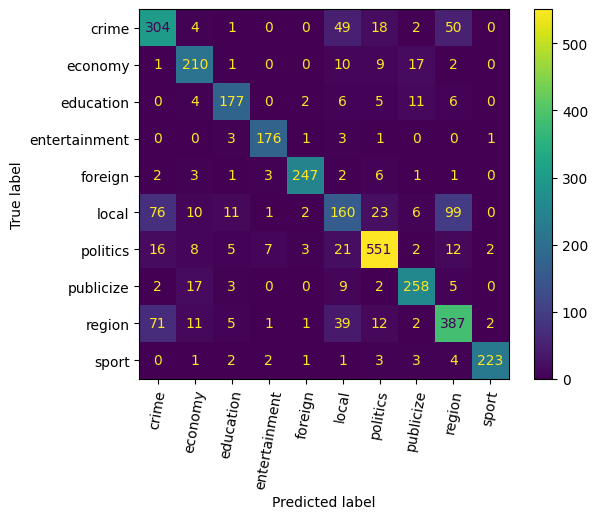

In [12]:
model_art_bi = train_predict(X_article_bigram, show_confusion_matrix=True)

- the score of the model using `article` and bigram feature is the best
- `local` is relatively low score (some are confused with `region`), while `sport` and `foreign` are very high 

# check the coefficient of the model
- coefficients show "for which category, which words are important" 
- `model` is a pipeline of `DictVectorizer` and `LogisticRegression`
- feature names (vocabulary) are in `model.named_steps['dv'].get_feature_names_out()`
- coefficients are in `model.named_steps['logreg'].coef_`, which is (`number of class` * `number of features`) array
- class names are in `model.named_steps['logreg'].classes_`

In [13]:
logreg = model_art_bi.named_steps['logreg']
dv = model_art_bi.named_steps['dv']

coef_df = pd.DataFrame(logreg.coef_, index=logreg.classes_, columns=dv.get_feature_names_out())
coef_df

\n      \n|      \n|      \n|      \n|      \n|       \
crime         -0.072428 -0.026369 -0.033083 -0.016363  0.001266  0.000543   
economy        0.064678  0.035222  0.154812  0.009268 -0.000764 -0.000935   
education     -0.378502 -0.040126 -0.015943 -0.000932 -0.003943 -0.001174   
entertainment  0.286143  0.023226  0.021268  0.016175  0.013338  0.010929   
foreign        0.117760 -0.044325 -0.015381 -0.007633 -0.002397 -0.001850   
local         -0.030495  0.081713 -0.017814  0.006495 -0.006919 -0.000847   
politics       0.094225 -0.069323 -0.016498 -0.004317 -0.003688 -0.001896   
publicize     -0.148751  0.114182 -0.044465  0.005895  0.006740  0.000623   
region        -0.069355 -0.076391 -0.019643 -0.004734 -0.001357 -0.002715   
sport          0.136724  0.002191 -0.013253 -0.003854 -0.002276 -0.002678   

               \n|        \n|          \n|           \n|              ...  \
crime          -0.001812    -0.009346     -0.000495        -0.008775  ...   
economy        -0.001391    -0.001902     -0.000338        -0.003795  ...   
education      -0.002073    -0.005301     -0.000714        -0.008067  ...   
entertainment   0.007956    -0.002325      0.002292        -0.003576  ...   
foreign        -0.001244    -0.001820     -0.000568        -0.003788  ...   
local          -0.001384    -0.009517     -0.002260        -0.017605  ...   
politics       -0.001716     0.000146      0.000903         0.005479  ...   
publicize      -0.001023    -0.002370     -0.000729        -0.003998  ...   
region          0.003999     0.036247      0.002313         0.049332  ...   
sport          -0.001312    -0.003812     -0.000403        -0.005206  ...   

               ü§öüèªü§öüèª#|myanchan         ü§£      ü§£|\n       ü§£|        ü§£ü§£ü§£  \
crime               -0.000141 -0.000231 -0.000113 -0.000117 -0.000110   
economy             -0.000149 -0.000186 -0.000144 -0.000042 -0.000097   
education           -0.000159 -0.000313 -0.000230 -0.000083 -0.000109   
entertainment        0.001569  0.002722  0.001782  0.000940  0.001161   
foreign             -0.000179 -0.000125 -0.000106 -0.000019 -0.000124   
local               -0.000190 -0.000409 -0.000289 -0.000119 -0.000173   
politics            -0.000248 -0.000421 -0.000161 -0.000260 -0.000147   
publicize           -0.000162 -0.000389 -0.000299 -0.000090 -0.000115   
region              -0.000138 -0.000438 -0.000282 -0.000156 -0.000130   
sport               -0.000203 -0.000210 -0.000157 -0.000053 -0.000156   

                  ü§£ü§£ü§£|          ü§´       ü§´|       ü§¨ü§¨ü§¨ü§¨  ü§¨ü§¨ü§¨ü§¨|‡πÄ‡∏Å‡πà‡∏á  
crime         -0.000110 -0.000208 -0.000208 -0.000241  -0.000241  
economy       -0.000097 -0.000177 -0.000177 -0.000121  -0.000121  
education     -0.000109 -0.000217 -0.000217 -0.000156  -0.000156  
entertainment  0.001161  0.002392  0.002392  0.001902   0.001902  
foreign       -0.000124 -0.000357 -0.000357 -0.000288  -0.000288  
local         -0.000173 -0.000297 -0.000297 -0.000295  -0.000295  
politics      -0.000147 -0.000324 -0.000324 -0.000351  -0.000351  
publicize     -0.000115 -0.000214 -0.000214 -0.000106  -0.000106  
region        -0.000130 -0.000299 -0.000299 -0.000200  -0.000200  
sport         -0.000156 -0.000298 -0.000298 -0.000144  -0.000144  

[10 rows x 1083083 columns]

In [14]:
## top 10 words for crime
## some are unigram feature
coef_df.loc['crime'].sort_values(ascending=False)[:10]

‡∏ï‡∏≥‡∏£‡∏ß‡∏à          0.382198
‡∏Ñ‡∏î‡∏µ            0.353687
‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà         0.334930
‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà|        0.310747
‡∏ú‡∏π‡πâ‡∏™‡∏∑‡πà‡∏≠‡∏Ç‡πà‡∏≤‡∏ß    0.306025
 |‡∏≠.           0.298359
‡∏≠.             0.293578
 |‡∏≠‡∏≤‡∏¢‡∏∏         0.290246
‡∏™‡∏≠‡∏ö‡∏™‡∏ß‡∏ô         0.288434
‡∏™‡∏ô.            0.287310
Name: crime, dtype: float64

In [15]:
## top 10 words for sports
coef_df.loc['sport'].sort_values(ascending=False)[:10]

‡∏ó‡∏µ‡∏°           0.776244
 |"           0.516734
‡∏Å‡∏µ‡∏¨‡∏≤          0.504528
"|            0.461302
‡∏Å‡∏≤‡∏£‡πÅ‡∏Ç‡πà‡∏á‡∏Ç‡∏±‡∏ô    0.459123
‡∏ü‡∏∏‡∏ï‡∏ö‡∏≠‡∏•        0.426619
‡∏ó‡∏µ‡∏°|‡∏ä‡∏≤‡∏ï‡∏¥      0.423024
‡∏®‡∏∂‡∏Å           0.412736
"             0.399781
‡πÄ‡∏Å‡∏°           0.376353
Name: sport, dtype: float64

# If remove stopwords/punctuations?
- there are a lot of punctuation/stopwords in the result above
- clean data and tokenize again 
- allowed token pattern is `[A-z0-9‡∏Å-‡πô\-\.]`
- not use bigram, because many words are removed

In [16]:
STOPWORDS = thai_stopwords()

# example of cleaning
def clean_and_tokenize(text:str):
    ### REMOVE URL ###
    text = html.unescape(urllib.parse.unquote(text)) # unescape for unicode, unquote for escaped URL
    text = re.sub(r'https?.+?(?:\s|$)', '', text) # remove URL link
    ### REMOVE EMOJI ###
    text = emoji.replace_emoji(text) # remove emoji
    ### REPLACE TEXT ###
    text = re.sub(r'[‚Äú‚Äù‚Äû]', '"', text) # convert double quotations into "
    text = re.sub(r'[‚Äò‚Äô‚Ä≤‚Ä≤‚Ä≤‚Ä≤`]', "'", text) # convert single quotations into '
    text = re.sub(r'[\n\t\u00a0\xa0\u3000\u2002-\u200a\u202f]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'[\u2028-\u202e]', '', text) # remove control puctuations 
    text = re.sub(r'‡πÄ‡πÄ', '‡πÅ', text)
    ### SHRINK SOME REDUPLICATION ###
    text = re.sub(r'‡∏≤‡∏≤+', '‡∏≤', text)
    text = re.sub(r'‡∏¢‡∏¢+', '‡∏¢', text)
    text = re.sub(r'‡πÜ‡πÜ+', '‡πÜ', text)
    text = re.sub(r'‡∏∞‡∏∞+', '‡∏∞', text)
    ### am ###
    text = re.sub(r'‡πç‡∏≤','‡∏≥', text) # o + ‡∏≤ -> ‡∏≥
    text = re.sub(r'\u0E33([\u0E48\u0E49\u0E4A\u0E4B])', r'\1'+'\u0E33', text) # am + tone -> tone + am
    ### TOKENIZE AND FILTERING ###
    tokens = word_tokenize(text.strip(), keep_whitespace=False)
    tokens = [token for token in tokens if re.match(r'[A-z0-9‡∏Å-‡πô\-\.]+', token) and (token not in STOPWORDS)]
    return tokens

In [18]:
# clening, remove stopwords, unigram feature
X_article_unigram_cleaned = df['article'].apply(clean_and_tokenize).apply(featurize_unigram)
train_predict(X_article_unigram_cleaned, return_model=False)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


               precision    recall  f1-score   support

        crime       0.62      0.68      0.65       428
      economy       0.77      0.79      0.78       250
    education       0.77      0.81      0.79       211
entertainment       0.91      0.96      0.93       185
      foreign       0.93      0.93      0.93       266
        local       0.50      0.38      0.43       388
     politics       0.86      0.86      0.86       627
    publicize       0.82      0.82      0.82       296
       region       0.68      0.72      0.70       531
        sport       0.94      0.92      0.93       240

     accuracy                           0.76      3422
    macro avg       0.78      0.79      0.78      3422
 weighted avg       0.76      0.76      0.76      3422



- The result is almost the same as the previous uniigram model (3)
- Removing stopwords/punctuation did not help to improve the model in this case

# Result Summary 

||train data|feature|F1 macro score|
|--:|---|---|---|
|1|headline|unigram|0.70|
|2|headline|bigram|0.71|
|3|article|unigram|0.79|
|4|article|bigram|0.81|
|5|article|unigram|0.78|

# Further Improvement

- to change cleaning/tokenizing method may be less helpful
- must modify featurize function
    - some category have specific characteristics except for tokens
    - e.g. `economy` may contain many digit characters -> try to use the feature such as `digit_char_ratio` 
- try other models e.g. Random Forest